# Bank_SentAnalysis_NB project

This project is meant to train a Naive Bayes Classifier in order to perform sentiment analysis over a set of reviews for banking services in the Italian language, scraped from TrustPilot.com

## 1. Setting everything up

First, we import the necessary libraries to load, manipulate and elaborate the data.

In [17]:
import json
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Now let's load the data, that has been previously scraped using the ```review_scraper.py``` script.

The data is structured as two JSON arrays, one per file. 

- The ```reviews.json``` file contains $m$ written reviews stored as strings.
- The ```ratings.json``` file contains $m$ ratings stored as integers from 1 to 5, in the same order as the reviews (meaning that the i-th rating is referred to the i-th review).



In [18]:
rev_file = open("reviews.json", "r", encoding="utf-8")
rat_file = open("ratings.json", "r", encoding="utf-8")
reviews = json.load(rev_file)
ratings = json.load(rat_file)

## 2. Data preprocessing
We now have to examine and filter the scraped data in order to get a better training set for our classifier.

Firstly, since we plan to classify a review's sentiment with a binary label (1 == positive, 0 == negative), we want to avoid training on lukewarm comments, and preserve either strongly positive or strongly negative reviews in our training set. 

A strongly opinionated review is defined by its related rating, in this case: $rating \le 2\ or \ge 4$.

In [19]:
polarized_ratings, polarized_reviews = [], []

for i in range(len(ratings)):
    rating = ratings[i]
    if rating >= 4 or rating <= 2:
        polarized_ratings.append(rating)
        polarized_reviews.append(reviews[i])

Let's now analyze the polarized reviews. We find out that the average rating hovers around 3.8 stars. This means that users are more likely to leave a positive review than a negative one, which might skew our algorithm towards misclassifying negative reviews as positive ones a little bit too often.

Average rating (polarized, not balanced): 3.789611435474129


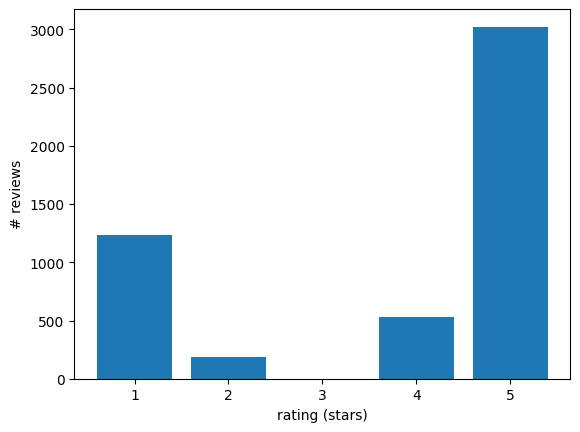

In [20]:
average_rating = sum(polarized_ratings) / len(polarized_ratings)
print("Average rating (polarized, not balanced):", average_rating)

ratings_dist = [len([review for review in polarized_ratings if review == i+1]) for i in range(5)]
plt.bar([1,2,3,4,5], ratings_dist, width=.8)
plt.xlabel("rating (stars)")
plt.ylabel("# reviews")
plt.show()

Let's try to build a more balanced training set. We can make use of all the negative samples, as they are the minority in our data set, so we will create a list of negative reviews and ratings. Then, we will create an equally long list of positive reviews and ratings.

In [21]:
ratings_balanced_neg, reviews_balanced_neg = [], []
ratings_balanced_pos, reviews_balanced_pos = [], []

for i in range(len(polarized_ratings)):
    rating = polarized_ratings[i]
    if rating <= 2:
        ratings_balanced_neg.append(rating)
        reviews_balanced_neg.append(polarized_reviews[i])

m = len(ratings_balanced_neg)

count = 0
for i in range(len(polarized_ratings)):
    if count == m: break
    rating = polarized_ratings[i]
    if rating >= 4:
        ratings_balanced_pos.append(rating)
        reviews_balanced_pos.append(polarized_reviews[i])
        count += 1

The ratings seem more balanced and closer to 3.0, great! 

The dataset is actually tending slightly towards "negativity" (defined as less than 3.0), meaning that disgruntled users might be slightly more inclined to leave a strong, 1-star negative review, than satisfied users are to leave a full 5-star review.

The ratings are now stored in the ```ratings_balanced``` list, which is simply the concatenation of the negative and positive reviews. This means that ```ratings_balanced[0]``` up to ```ratings_balanced[m-1]``` is going to contain negative reviews only, while ```ratings_balanced[m]``` up to ```ratings_balanced[m*2-1]``` will contain positive reviews only.

Average rating (polarized, balanced): 2.9594499294781382


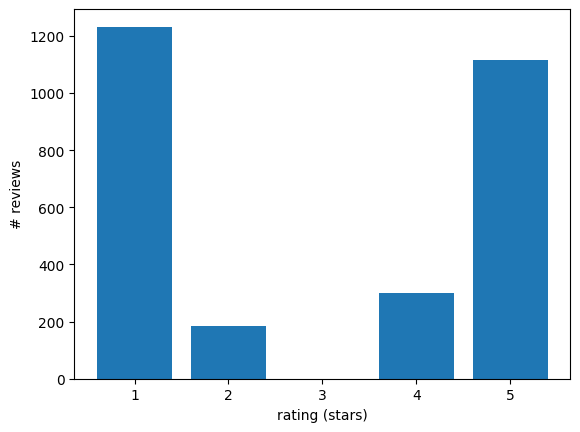

In [22]:
ratings_balanced = ratings_balanced_neg + ratings_balanced_pos
reviews_balanced = reviews_balanced_neg + reviews_balanced_pos
print("Average rating (polarized, balanced):", sum(ratings_balanced)/len(ratings_balanced))

ratings_dist = [len([review for review in ratings_balanced if review == i+1]) for i in range(5)]

plt.bar([1,2,3,4,5], ratings_dist, width=.8)
plt.xlabel("rating (stars)")
plt.ylabel("# reviews")
plt.show()

Now we define the function to process the reviews. We want to clean and tokenize each of them in order to feed them to our classifier.

In [23]:
def process_content(reviews):
    processed_reviews = []
    stemmer = SnowballStemmer('italian')
    stop_words = set(stopwords.words('italian'))

    for review in reviews:
        review = re.sub(r'http\S+', '', review, flags=re.MULTILINE)     # remove URLs
        review = word_tokenize(review)                                  # tokenize review
        review = [word for word in review if word not in stop_words]    # filter out stop words
        review = [stemmer.stem(word) for word in review]                # stem words
        processed_reviews.append(review)

    return processed_reviews

We now create the full set (later to be divided in training, validating and testing)

In [24]:
X_tot = process_content(reviews_balanced)
y_tot = [0]*m + [1]*m

## 3. Training the algorithm

The algorithm we're about to use is a very simple Naive Bayes implementation. The algorithm estimates the sentiment of a document (a tweet, a review, etc.) as a real number in the interval $ (-\inf, +\inf) $, where $0$ means total neutrality, a positive or negative number estimates a positive or negative sentiment, respectively.

To have the algorithm calculate this number, the following steps are necessary as training procedure:

1. We fill a frequency table containing, for each word, the number of times it has appeared in positive reviews and negative reviews respectively. 
Note: we expect "neutral" (sentiment-wise) words to appear in similar quantities both in positive and negative reviews, while words that are more strongly correlated with a sentiment will be distributed in a more unbalanced fashion.

2. We fill the lambda table which, for each word

Now we need to fill our frequency table. The frequency table stores how many times each word has appeared in positive and negative reviews.

|  | positive frequency | negative frequency |
|----------|----------|----------|
| word 1    | 5   | 3   |
| word 2    | 10    | 25    |
| word 3    | 102    | 32   |
| ...    | ...    | ...    |


In [25]:
def frequency_table(reviews, ratings):
    freqt = {}

    i = 0
    for review in reviews:
        label = ratings[i]
        for word in review:
            val = freqt.get((word,label), 0)        # get previous frequency value (0 if not existent)
            freqt[(word, label)] = val + 1          # increase previous value by 1 and update the freq table
        i = i + 1

    return freqt

In [26]:
freqt = frequency_table(X_tot, y_tot)
print(freqt)

{('le', 0): 35, ('esperit', 0): 119, ('banc', 0): 877, ('widib', 0): 220, ('stat', 0): 558, ('insoddisfacent', 0): 2, ('chiest', 0): 109, ('volt', 0): 283, ('deposit', 0): 17, ("l'ultim", 0): 18, ('cost', 0): 74, ('21k', 0): 1, ('insopport', 0): 2, ('.', 0): 3525, ('nonost', 0): 100, ('reclam', 0): 45, ('team', 0): 12, ('support', 0): 30, (',', 0): 4236, ('ricev', 0): 212, ('rispost', 0): 284, ('sospes', 0): 18, ('oltre', 0): 95, ('due', 0): 166, ('mes', 0): 404, ('senz', 0): 351, ('alcun', 0): 151, ('progress', 0): 2, ('fortunat', 0): 6, ("l'incred", 0): 1, ('squadr', 0): 1, ('di𝗦𝗨𝗣𝗥𝗘𝗠𝗘', 0): 1, ('𝗔𝗦𝗦𝗘𝗧𝗦', 0): 1, ('𝗥𝗘𝗖𝗢𝗩𝗘𝗥𝗬', 0): 1, ('•𝗢-𝗥-𝗚mi', 0): 1, ('aiut', 0): 63, ('recuper', 0): 33, ('finanz', 0): 32, ('graz', 0): 39, ('grat', 0): 1, ('camb', 0): 166, ('condizion', 0): 45, ('assicur', 0): 25, ('client', 0): 606, ('recep', 0): 2, ('comun', 0): 89, ('serviz', 0): 402, ('terz', 0): 14, ('mond', 0): 22, ('!', 0): 1295, ('se', 0): 80, ('acced', 0): 72, ('sit', 0): 105, ('riman', 0): 

Once we have our frequency table filled, we can use it to calculate the $\lambda(w)$ table, which uses basic probability to determine "how positive" or "how negative" a word is.

|  | $\lambda(w)$ |
|----------|----------|
| word 1    | 0   |
| word 2    | 104.2    |
| word 3    | -1.5    |
| ...    | ...    |

In [27]:
def train_nb(freqt):

    # get all instances of positive and negative words
    n_pos = sum([i for ((_,t),i) in freqt.items() if t == 1])
    n_neg = sum([i for ((_,t),i) in freqt.items() if t == 0])
    n_arr = [n_neg, n_pos]

    # get the set of unique words throughout all classes, to calculate vocabulary size
    unique_set = set([w for ((w,_),_) in freqt.items()])
    V = len(unique_set)

    probt = {}
    logprior = np.log(n_pos / (n_pos + n_neg))

    for word in unique_set:
        probt[(word, 0)] = (freqt.get((word,0),0) + 1) / (n_arr[0] + V)
        probt[(word, 1)] = (freqt.get((word,1),0) + 1) / (n_arr[1] + V)

    lambdat = {}
    for word in unique_set:
        lambdat[word] = np.log(probt[(word, 1)] / probt[(word, 0)])

    return lambdat, logprior


In [28]:
def bayes_prediction(sentence, lambdat, logprior):
    words = process_content([sentence])
    result = 0
    for word in words[0]:
        result += lambdat.get(word, 1)
        
    return result + logprior

In [29]:
lambdat, logprior = train_nb(freqt)

In [32]:
print(bayes_prediction("sono stato profondamente deluso da questa banca.", lambdat, logprior))

-3.934197569234501


In [ ]:
lambda_file = open("lambda.csv", "w")
lambdat_sorted = dict(sorted(lambdat.items(), key=lambda x: x[1]))

lambda_file = open("lambda.json", "w")
json.dump(lambdat_sorted, lambda_file)